# PRO

In [20]:
import numpy as np
import pandas as pd

## Passo 1: Leitura dos dados
Leitura dos bancos de dados em DataFrame Pandas. 

In [21]:
caminho_dados_lazaro = 'Datasets/Lazaro/dados_pre_processados_lazaro.csv'

In [22]:
df = pd.read_csv(caminho_dados_lazaro)

In [23]:
df.head()

,Piquete,Altura real,Altura esperada,Animal,SensorID,Sensor Name,Date,X,Y,Z,Comportamento,Season_fall,Season_spring,Season_summer,magn,sma,ent,pit,rol,icl
0,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:47,-0.132,-0.583,0.712,Ocio,0.0,1.0,0.0,0.929654,1.427,-0.005973,8.162915,129.311311,40.014999
1,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:48,0.021,-0.792,0.574,Ocio,0.0,1.0,0.0,0.978356,1.387,-0.282943,-1.229924,144.067373,54.076939
2,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:50,0.021,-0.792,0.574,Ocio,0.0,1.0,0.0,0.978356,1.387,-0.282943,-1.229924,144.067373,54.076939
3,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:51,0.021,-0.792,0.574,Ocio,0.0,1.0,0.0,0.978356,1.387,-0.282943,-1.229924,144.067373,54.076939
4,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:52,-0.061,-0.870,0.478,Ocio,0.0,1.0,0.0,0.994538,1.409,-0.361029,3.516446,151.214493,61.273746


In [24]:
# Remove as linhas com o sensor 434138
df = df[df.SensorID != 434138]

## Passo 2: Treinamento e Validação

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
# Para a busca do melhores hiperparêmetros
from sklearn.model_selection import RandomizedSearchCV
from skopt import gp_minimize

### Seleção de colunas aplicáveis

In [26]:
df.columns

Index(['Piquete', 'Altura real', 'Altura esperada', 'Animal', 'SensorID',
       'Sensor Name', 'Date', 'X', 'Y', 'Z', 'Comportamento', 'Season_fall',
       'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol',
       'icl'],
      dtype='object')

In [27]:
# Lista com os atributos aplicáveis
features_aplicaveis = ['X', 'Y' ,'Z', 'Comportamento', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']

# Seleciona os abributos correspondentes da lista features_aplicaveis
df = df[features_aplicaveis]

#### Função para imprimir a quantidade de dados por conjunto

In [28]:
def imprimir_quantidade_dados(X_train, X_test):
    print(10*"-"," Quantidade de dados ",  10*"-")
    
    print('Treino: ', X_train.shape[0])
    print('Teste: ', X_test.shape[0])
    
    print(43*"-")

#### Divisão entre variáveis preditoras(X) e variáveis de resposta(y)

In [29]:
y = df.Comportamento
X = df.drop('Comportamento', axis=1)

# Conjunto de dados PRO: Pastejando x Ruminando x Ócio
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 0, stratify=y)

##### Quantidade de dados por conjunto

In [30]:
imprimir_quantidade_dados(X_train, X_test)

----------  Quantidade de dados  ----------
Treino:  485720
Teste:  121430
-------------------------------------------


In [31]:
# Para reescalar os dados
from sklearn.preprocessing import StandardScaler

X_train_season = X_train[['Season_fall', 'Season_spring', 'Season_summer']]
X_test_season =  X_test[['Season_fall', 'Season_spring', 'Season_summer']]

X_train.drop(['Season_fall', 'Season_spring', 'Season_summer'], axis=1, inplace=True)
X_test.drop(['Season_fall', 'Season_spring', 'Season_summer'], axis=1, inplace=True)

columns = X_train.columns
index_train = X_train.index
index_test = X_test.index


sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

X_train = pd.DataFrame(X_train, columns=columns, index=index_train)
X_test = pd.DataFrame(X_test, columns=columns, index=index_test)

X_train = pd.concat([X_train, X_train_season], axis=1)
X_test = pd.concat([X_test, X_test_season], axis=1)

In [32]:
del X_test_season
del X_train_season

### Função para imprimir e salvar matriz de confusão

In [14]:
# Função para imprimir e salvar matriz de confusão
def imprimeMatrizDeConfusão(y_test, preds, model, salvarFigura = False):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_test, preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(values_format= '.2%', xticks_rotation=60, colorbar=False)
    disp.ax_.set_title("Matriz de confusão normalizada sobre as condições verdadeiras")
    if(salvarFigura):
        plt.savefig(input('Nome da figura a ser salva:' ) + '.png')
    plt.show()

In [15]:
from sklearn.metrics import classification_report

def classification_report_extendido(y_true: np.array, y_pred: np.array, classes: set = None):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    if classes is None: # Determina classes pelos valores
        classes = set(np.concatenate((np.unique(y_true), np.unique(y_pred))))
    for cls in classes:
        y_true_cls = (y_true == cls).astype(int)
        y_pred_cls = (y_pred == cls).astype(int)

        fp = sum(y_pred_cls[y_true_cls != 1])
        tn = sum(y_pred_cls[y_true_cls == 0] == False)
        fn = sum(y_pred_cls[y_true_cls == 1] == False)

        
        specificity_val = tn / (tn + fp)
        report[cls]['specificity'] = specificity_val
        npv_val = tn / (tn + fn)
        report[cls]['npv'] = npv_val
        
    return report

### GLM 

In [89]:
from patsy import dmatrices
import statsmodels.api as sm

In [90]:
df_train = pd.concat([X_train, y_train], axis=1)

In [91]:
y_train, X_train = dmatrices( 'Comportamento ~ X + Y + Z + Season_fall + Season_spring + Season_summer + magn + sma + ent + pit + rol + icl', data=df_train, return_type='dataframe')

In [92]:
glm_model = sm.MNLogit(y_train, X_train) 

In [93]:
%%time
glm_results = glm_model.fit()

df_test = pd.concat([X_test, y_test], axis=1)

y_test, X_test = dmatrices( 'Comportamento ~ X + Y + Z + Season_fall + Season_spring + Season_summer + magn + sma + ent + pit + rol + icl', data=df_test, return_type='dataframe')

preds = glm_results.predict(X_test)

Optimization terminated successfully.
         Current function value: 0.951639
         Iterations 6
CPU times: user 11.1 s, sys: 112 ms, total: 11.2 s
Wall time: 2.87 s


In [94]:
preds[3] = preds.median(axis=1)

In [71]:
preds = preds.reset_index(drop=True)

In [72]:
b = np.zeros((preds.shape[0], 3))

In [73]:
for i in range(preds.shape[0]):
    for j in range(3):
        if preds.loc[i,j] > preds.loc[i,3]:
            b[i,j] = 1
        else:
            b[i,j] = 0

In [74]:
preds = pd.DataFrame(b, columns=['Ocio', 'Pastejando', 'Ruminando'])

In [75]:
accuracy_score(y_test, preds)*100

56.88874248538253

In [52]:
print(classification_report(y_test, preds, digits=3))

              precision    recall  f1-score   support

           0      0.359     0.101     0.158     24652
           1      0.593     0.916     0.720     66502
           2      0.484     0.187     0.270     30276

   micro avg      0.569     0.569     0.569    121430
   macro avg      0.479     0.402     0.383    121430
weighted avg      0.518     0.569     0.494    121430
 samples avg      0.569     0.569     0.569    121430



In [53]:
# Reverso de get_dummies
preds = preds.idxmax(axis=1)

In [54]:
y_test = y_test.rename(columns={"Comportamento[Ocio]" : "Ocio", "Comportamento[Pastejando]" : "Pastejando", "Comportamento[Ruminando]" : "Ruminando"})

In [55]:
y_test = y_test.idxmax(axis=1)

In [56]:
y_test = y_test.reset_index(drop=True)

In [57]:
classification_report_extendido(y_test, preds)

{'Ocio': {'precision': 0.3594874748056435,
  'recall': 0.10128995619016713,
  'f1-score': 0.1580479777201089,
  'support': 24652,
  'specificity': 0.9540288082002107,
  'npv': 0.8064795080535271},
 'Pastejando': {'precision': 0.5927234158492916,
  'recall': 0.915957414814592,
  'f1-score': 0.7197140662846341,
  'support': 66502,
  'specificity': 0.23800247596854063,
  'npv': 0.7005144143178652},
 'Ruminando': {'precision': 0.48395356777057014,
  'recall': 0.1872770511296076,
  'f1-score': 0.27005143836921314,
  'support': 30276,
  'specificity': 0.9336726857844966,
  'npv': 0.7757259784530689},
 'accuracy': 0.5688874248538253,
 'macro avg': {'precision': 0.47872148614183513,
  'recall': 0.4015081407114556,
  'f1-score': 0.38260449412465203,
  'support': 121430},
 'weighted avg': {'precision': 0.5182537762294335,
  'recall': 0.5688874248538253,
  'f1-score': 0.49357408326511704,
  'support': 121430}}

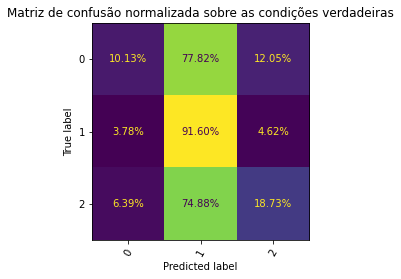

In [58]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format= '.2%', xticks_rotation=60, colorbar=False)
disp.ax_.set_title("Matriz de confusão normalizada sobre as condições verdadeiras")
plt.show()

### LGBMClassifier

In [114]:
from lightgbm import LGBMClassifier

In [212]:
lgb_model = LGBMClassifier(n_jobs=-1, random_state=0)
lgb_model.fit(X_train, y_train)

lgb_preds = lgb_model.predict(X_test)

accuracy_score(y_test, lgb_preds)*100

77.83414312772791

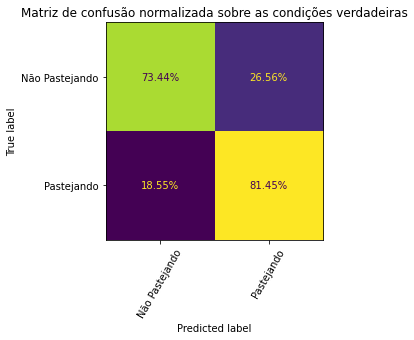

In [213]:
imprimeMatrizDeConfusão(y_test, lgb_preds, lgb_model)

#### LGB: Busca de melhores hiper parâmetros

In [95]:
def tune_lgb(params):
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    
    print(params, '\n')
    
    lgb_Model = LGBMClassifier(learning_rate=learning_rate, num_leaves=num_leaves, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree, random_state=0, subsample_freq=1, 
                         n_estimators=100, n_jobs=-1)
    
    auc = cross_val_score(lgb_Model, X_train, y_train, cv=3, scoring ='accuracy')
    
    return -auc.mean()

space = [(1e-3, 1e-1, 'log-uniform'), #learning rate
         (2, 512), # num_leaves
         (1, 500), # min_child_samples
         (0.05, 1.0), # subsample
         (0.1, 1.0)] # colsample bytree

In [51]:
%%time
resultados_lgb = gp_minimize(tune_lgb, space, random_state=0, verbose=1, n_calls=50, n_random_starts=10, n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
[0.015335192657991574, 433, 429, 0.8548891518449193, 0.6612073271073752] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 29.7196
Function value obtained: -0.7125
Current minimum: -0.7125
Iteration No: 2 started. Evaluating function at random point.
[0.005871694001325899, 154, 29, 0.30902347985110756, 0.529898605589215] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 14.8425
Function value obtained: -0.6312
Current minimum: -0.7125
Iteration No: 3 started. Evaluating function at random point.
[0.04210536704211821, 247, 197, 0.8442748253605089, 0.40365654437554166] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 18.5394
Function value obtained: -0.7245
Current minimum: -0.7245
Iteration No: 4 started. Evaluating function at random point.
[0.01978535031094702, 190, 479, 0.1833332413920129, 0.8830785325225929] 

Iteration No: 4 ended. Evaluation done at random poi

In [52]:
resultados_lgb.x

[0.1, 512, 1, 1.0, 0.6446300002048094]

In [19]:
# Melhores hiper parâmetros para o conjunto PRO: learning_rate=0.1, num_leaves=512, min_child_samples=1, subsample=1.0, colsample_bytree=0.662, random_state=0, subsample_freq=1, n_estimators=100, n_jobs=-1

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

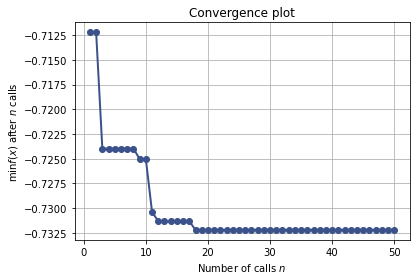

In [18]:
from skopt.plots import plot_convergence
plot_convergence(resultados_lgb)

In [36]:
# Melhores hiper parâmetros para o conjunto PNP: learning_rate=0.1, num_leaves=512, min_child_samples=88, subsample=0.729, colsample_bytree=0.671, random_state=0, subsample_freq=1, n_estimators=100, n_jobs=-1

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

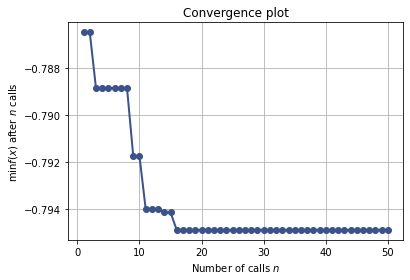

In [86]:
from skopt.plots import plot_convergence
plot_convergence(resultados_lgb)

#### LGB: Treinamento com os melhores hiper parâmetros

In [115]:
%%time
lgb_model = LGBMClassifier(learning_rate=0.1, num_leaves=512, min_child_samples=1, subsample=1.0, colsample_bytree=0.662, random_state=0, subsample_freq=1, n_estimators=100, n_jobs=-1)
lgb_model.fit(X_train, y_train)

lgb_preds = lgb_model.predict(X_test)

accuracy_score(y_test, lgb_preds)*100

CPU times: user 1min 5s, sys: 588 ms, total: 1min 5s
Wall time: 8.76 s


73.3846660627522

In [116]:
classification_report_extendido(y_test, lgb_preds)

{'Ocio': {'precision': 0.6430406429088993,
  'recall': 0.39599221158526693,
  'f1-score': 0.4901463610574147,
  'support': 24652,
  'specificity': 0.944005869102482,
  'npv': 0.8598575045412192},
 'Pastejando': {'precision': 0.7675435767092005,
  'recall': 0.8945595621184326,
  'f1-score': 0.8261983626023374,
  'support': 66502,
  'specificity': 0.671988785318963,
  'npv': 0.8403569883660041},
 'Ruminando': {'precision': 0.6909400876765709,
  'recall': 0.6559320914255516,
  'f1-score': 0.6729811244027246,
  'support': 30276,
  'specificity': 0.902549531561972,
  'npv': 0.8876122043846021},
 'accuracy': 0.733846660627522,
 'macro avg': {'precision': 0.7005081024315568,
  'recall': 0.6488279550430837,
  'f1-score': 0.6631086160208256,
  'support': 121430},
 'weighted avg': {'precision': 0.7231682694704875,
  'recall': 0.733846660627522,
  'f1-score': 0.7197735989869465,
  'support': 121430}}

In [122]:
print(classification_report(y_test, lgb_preds, digits=3))

              precision    recall  f1-score   support

        Ocio      0.643     0.396     0.490     24652
  Pastejando      0.768     0.895     0.826     66502
   Ruminando      0.691     0.656     0.673     30276

    accuracy                          0.734    121430
   macro avg      0.701     0.649     0.663    121430
weighted avg      0.723     0.734     0.720    121430



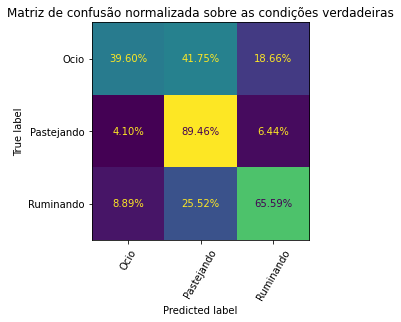

In [123]:
imprimeMatrizDeConfusão(y_test, lgb_preds, lgb_model)

In [124]:
lgb_preds = lgb_model.predict(X_train)

accuracy_score(y_train, lgb_preds)*100

77.02009388124846

### Random Forest

In [51]:
from sklearn.ensemble import RandomForestClassifier

#### Com Randomized Search CV

In [39]:
rf_Model = RandomForestClassifier(random_state=0, n_jobs=-1)

In [40]:
# Create the param grid
rf_param_grid = {'n_estimators':  np.arange(50, 250, 50),
               'max_features': ['auto', 'sqrt'],
               'max_depth':[50, 100, 150, None],
               'criterion': ['gini', 'entropy'],
               'min_samples_split': [2, 5, 10, 30, 50],
               'min_samples_leaf': [1, 2],
               'bootstrap': [True, False]}

In [41]:
rf_RandomGrid = RandomizedSearchCV(estimator = rf_Model, param_distributions = rf_param_grid, cv = 3, verbose=1, random_state=0)

In [ ]:
%%time
rf_RandomGrid.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [46]:
rf_RandomGrid.best_params_

{'n_estimators': 150,
 'min_samples_split': 30,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100,
 'criterion': 'entropy',
 'bootstrap': False}

In [48]:
rf_RandomGrid.best_score_

0.7361747363918738

In [50]:
preds_rf_RG = rf_RandomGrid.predict(X_test)

In [51]:
accuracy_score(y_test, preds_rf_RG)*100

74.09413128837589

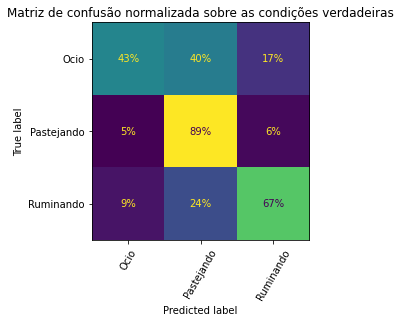

In [52]:
imprimeMatrizDeConfusão(y_test, preds_rf_RG, rf_RandomGrid)

#### RF: Busca de melhores hiper parâmetros

In [92]:
def tune_rf(params):
    n_estimators = params[0]
    max_features = params[1]
    max_depth = params[2]
    criterion = params[3]
    min_samples_split = params[4]
    min_samples_leaf = params[5]
    bootstrap = params[6]
    
    print(params, '\n')
    
    rf_Model = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, criterion=criterion, min_samples_split=min_samples_split,
                                       min_samples_leaf = min_samples_leaf, bootstrap=bootstrap, random_state=0, n_jobs=-1)
    
    auc = cross_val_score(rf_Model, X_train, y_train, cv=3, scoring ='accuracy')
    
    return -auc.mean()

space = [ np.arange(50, 250, 50), # n_estimators
         ['auto', 'sqrt'], # max_features
         [50, 100, 150, None], # max_depth
         ['gini', 'entropy'], # criterion
         [2, 5, 10, 30, 50], # min_samples_split
         [1,2,4], # min_samples_leaf
         [True, False]] # bootstrap] 

In [93]:
%%time
from skopt import forest_minimize
resultado_rf = gp_minimize(tune_rf, space, random_state=0, verbose=1, n_calls=30, n_random_starts=15, n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
[150, 'sqrt', None, 'gini', 10, 2, False] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 118.0591
Function value obtained: -0.7941
Current minimum: -0.7941
Iteration No: 2 started. Evaluating function at random point.
[50, 'auto', 100, 'gini', 10, 2, True] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 31.4995
Function value obtained: -0.7960
Current minimum: -0.7960
Iteration No: 3 started. Evaluating function at random point.
[100, 'sqrt', 100, 'gini', 5, 4, False] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 78.5794
Function value obtained: -0.7949
Current minimum: -0.7960
Iteration No: 4 started. Evaluating function at random point.
[150, 'sqrt', 150, 'gini', 10, 2, True] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 85.1647
Function value obtained: -0.7974
Current minimum: -0.7974
Iteration No: 5 started. Evaluating function a

In [96]:
resultado_rf.x

[200, 'sqrt', 50, 'entropy', 30, 1, True]

In [63]:
# Melhores hiper parâmetros para o conjunto PRO: n_estimators=200, max_features='sqrt', max_depth=None, criterion='entropy', min_samples_split=10, min_samples_leaf=2 , bootstrap=True, random_state=0, n_jobs=-1

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

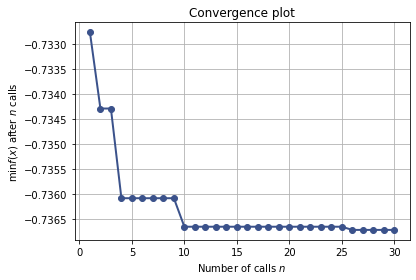

In [64]:
from skopt.plots import plot_convergence
plot_convergence(resultado_rf)

In [97]:
# Melhores hiper parâmetros para o conjunto PNP: n_estimators=200, max_features='sqrt', max_depth=50, criterion='entropy', min_samples_split=30, min_samples_leaf=1 , bootstrap=True, random_state=0, n_jobs=-1

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

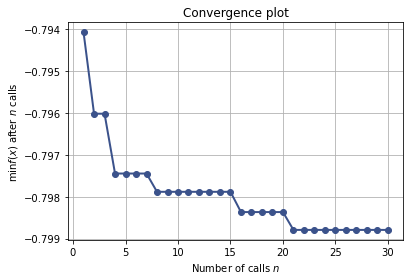

In [95]:
from skopt.plots import plot_convergence
plot_convergence(resultado_rf)

#### RF: Treinamento com os melhores hiper parâmetros

In [117]:
%%time
rf_model = RandomForestClassifier(n_estimators=200, max_features='sqrt', max_depth=None, criterion='entropy',
                                  min_samples_split=10, min_samples_leaf=2 , bootstrap=True, random_state=0, n_jobs=-1)
rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_test)

CPU times: user 9min 16s, sys: 902 ms, total: 9min 17s
Wall time: 1min 16s


In [118]:
accuracy_score(y_test, preds)*100

74.15465700403526

In [119]:
classification_report_extendido(y_test, preds)

{'Ocio': {'precision': 0.6475815590147314,
  'recall': 0.44045107901995784,
  'f1-score': 0.524300441826215,
  'support': 24652,
  'specificity': 0.9389427349190932,
  'npv': 0.8682055740806207},
 'Pastejando': {'precision': 0.776104509945513,
  'recall': 0.8888755225406755,
  'f1-score': 0.8286709610491565,
  'support': 66502,
  'specificity': 0.6895390329158171,
  'npv': 0.8367392024743179},
 'Ruminando': {'precision': 0.7044704891571338,
  'recall': 0.6630994847403884,
  'f1-score': 0.6831592200632933,
  'support': 30276,
  'specificity': 0.9076069069925621,
  'npv': 0.8902423277234968},
 'accuracy': 0.7415465700403525,
 'macro avg': {'precision': 0.7093855193724594,
  'recall': 0.6641420287670072,
  'f1-score': 0.6787102076462216,
  'support': 121430},
 'weighted avg': {'precision': 0.7321521143288237,
  'recall': 0.7415465700403525,
  'f1-score': 0.7305991871055516,
  'support': 121430}}

In [120]:
print(classification_report(y_test, preds, digits=3))

              precision    recall  f1-score   support

        Ocio      0.648     0.440     0.524     24652
  Pastejando      0.776     0.889     0.829     66502
   Ruminando      0.704     0.663     0.683     30276

    accuracy                          0.742    121430
   macro avg      0.709     0.664     0.679    121430
weighted avg      0.732     0.742     0.731    121430



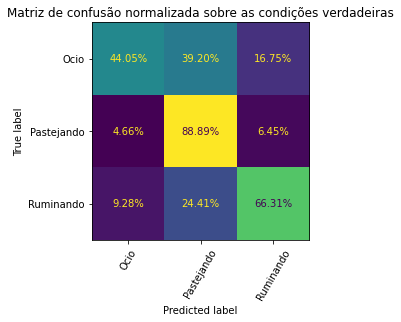

In [121]:
imprimeMatrizDeConfusão(y_test, preds, rf_model)

### Gradient Boosting

In [125]:
from xgboost import XGBClassifier

In [126]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()

y_train_ordinal = ordinal_encoder.fit_transform(y_train.array.reshape(-1,1))
y_test_ordinal = ordinal_encoder.transform(y_test.array.reshape(-1,1))

In [109]:
xgb_model = XGBClassifier(use_label_encoder=False, random_state=0)
xgb_model.fit(X_train, y_train_ordinal)

[16:42:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [110]:
xgb_preds = xgb_model.predict(X_test)
xgb_preds = ordinal_encoder.inverse_transform(xgb_preds.reshape(-1,1))
accuracy_score(y_test, xgb_preds)*100

71.71539158362843

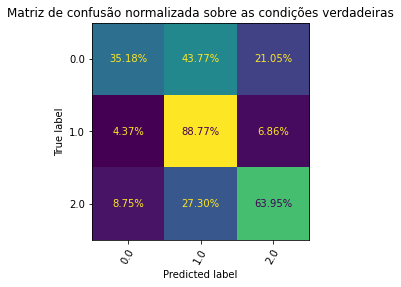

In [111]:
imprimeMatrizDeConfusão(y_test, xgb_preds, xgb_model)

#### GB: Busca de melhores hiper parâmetros

In [112]:
def tune_gb(params):
    learning_rate = params[0]
    max_depth = params[1]
    min_child_weight = params[2]
    gamma = params[3]
    colsample_bytree = params[4]
    
    print(params, '\n')
    
    gb_Model = XGBClassifier(learning_rate=learning_rate, max_depth=max_depth, min_child_weight=min_child_weight, colsample_bytree=colsample_bytree,
                             use_label_encoder=False, random_state=0, n_jobs=-1)
    
    auc = cross_val_score(gb_Model, X_train, y_train_ordinal, cv=3, scoring ='accuracy')
    
    return -auc.mean()

space = [(1e-3, 1e-1, 'log-uniform'), #learning rate
         (2, 16), # max_depth
         (1, 16), # min_child_weight
         (0.0, 0.5), # gamma
         (0.1, 1.0)] # colsample bytree

In [ ]:
%%time
resultados_gb = gp_minimize(tune_gb, space, random_state=0, verbose=1, n_calls=30, n_random_starts=10, n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
[0.015335192657991574, 14, 14, 0.4236258693920628, 0.6612073271073752] 

[16:43:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:44:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:46:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 244.4441
Function value obtained: -0.7

In [ ]:
resultados_gb.x

[0.1, 16, 1, 0.0, 0.5370264280766771]

In [ ]:
# Melhores hiper parâmetros para o conjunto PRO: learning_rate=0.1, max_depth=16, min_child_weight=1, gamma=0.0, colsample_bytree=0.5370264280766771, use_label_encoder=False, random_state=0, n_jobs=-1

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

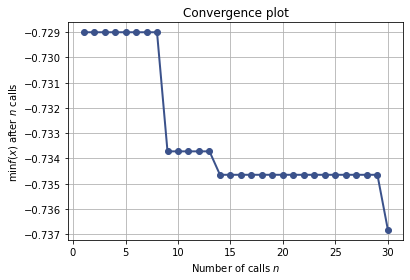

In [117]:
from skopt.plots import plot_convergence
plot_convergence(resultados_gb)

In [87]:
# Melhores hiper parâmetros para o conjunto PNP: learning_rate=0.008851671496973969, max_depth=16, min_child_weight=1, gamma=0.0, colsample_bytree=0.631278076735511, use_label_encoder=False, random_state=0, n_jobs=-1

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

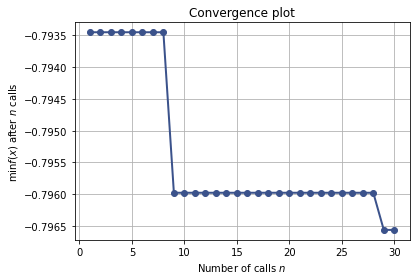

In [85]:
plot_convergence(resultados_gb)

#### GB: Treinamento com os melhores hiper parâmetros

In [128]:
%%time
gb_model = XGBClassifier(learning_rate=0.1, max_depth=16, min_child_weight=1, gamma=0.0,
                         colsample_bytree=0.5370264280766771, use_label_encoder=False, random_state=0, n_jobs=-1)

gb_model.fit(X_train, y_train_ordinal)
preds = gb_model.predict(X_test)

[19:30:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 17min 26s, sys: 13 s, total: 17min 39s
Wall time: 2min 22s


In [58]:
preds = ordinal_encoder.inverse_transform(preds.reshape(-1,1))
accuracy_score(y_test, preds)*100

74.29218479782591

In [59]:
classification_report_extendido(y_test, preds)

{'Ocio': {'precision': 0.6573417878900908,
  'recall': 0.4289307155606036,
  'f1-score': 0.5191221954931514,
  'support': 24652,
  'specificity': array([0.94304491]),
  'npv': array([0.86636163])},
 'Pastejando': {'precision': 0.7749100578758017,
  'recall': 0.8939280021653484,
  'f1-score': 0.830174978005558,
  'support': 66502,
  'specificity': array([0.68562482]),
  'npv': array([0.8422418])},
 'Ruminando': {'precision': 0.705288528713148,
  'recall': 0.6668978729026291,
  'f1-score': 0.6855561591742495,
  'support': 30276,
  'specificity': array([0.90744235]),
  'npv': array([0.89132777])},
 'accuracy': 0.7429218479782591,
 'macro avg': {'precision': 0.71251345815968,
  'recall': 0.6632521968761937,
  'f1-score': 0.6782844442243197,
  'support': 121430},
 'weighted avg': {'precision': 0.7336833889421259,
  'recall': 0.7429218479782591,
  'f1-score': 0.7309692417506576,
  'support': 121430}}

In [17]:
print(classification_report(y_test, preds, digits=3))

              precision    recall  f1-score   support

        Ocio      0.657     0.429     0.519     24652
  Pastejando      0.775     0.894     0.830     66502
   Ruminando      0.705     0.667     0.686     30276

    accuracy                          0.743    121430
   macro avg      0.713     0.663     0.678    121430
weighted avg      0.734     0.743     0.731    121430



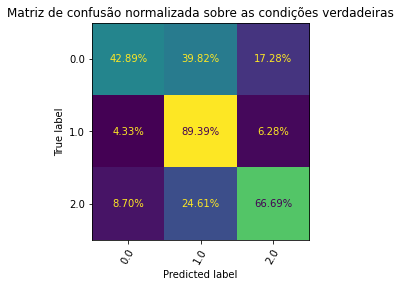

In [18]:
imprimeMatrizDeConfusão(y_test, preds, gb_model)

### SVM

In [21]:
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, random_state = 0)

In [ ]:
%%time
svc_model = SVC(kernel='linear', cache_size=5000, random_state=0) # Linear Kernel

svc_model.fit(X_train, y_train)

svc_preds = svc_model.predict(X_test)

In [ ]:
print("Acurácia:", accuracy_score(y_test, svc_preds))

###  Gaussian Naive Bayes

In [105]:
# Conjunto com todas as classes
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [106]:
from sklearn.naive_bayes import GaussianNB

In [107]:
gnb_model = GaussianNB()
gnb_preds = gnb_model.fit(X_train, y_train).predict(X_test)
print("Acurácia:", accuracy_score(y_test, gnb_preds))

Acurácia: 0.5575803093788705


### Logistic Regression

In [114]:
# Conjunto de dados PNP: Pastejando x Não Pastejando
y_pnp = y
y_pnp = y_pnp.replace(to_replace=['Agua', 'Locomovendo', 'Ocio', 'Outros','Ruminando'], value='Não Pastejando')
X_train, X_test, y_train, y_test = train_test_split(X, y_pnp, random_state = 0)

In [118]:
from sklearn.linear_model import LogisticRegression

In [128]:
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [129]:
lr_preds = lr_model.predict(X_test)

In [130]:
print("Acurácia:", accuracy_score(y_test, lr_preds))

Acurácia: 0.6313740216617915


### Redes Neurais

In [60]:
from sklearn.neural_network import MLPClassifier

In [20]:
rn_model = MLPClassifier(random_state=0)
rn_model.fit(X_train, y_train.values)

MLPClassifier(random_state=0)

In [21]:
rn_preds = rn_model.predict(X_test)

In [22]:
print("Acurácia:", accuracy_score(y_test, rn_preds)*100)

Acurácia: 69.89376595569465


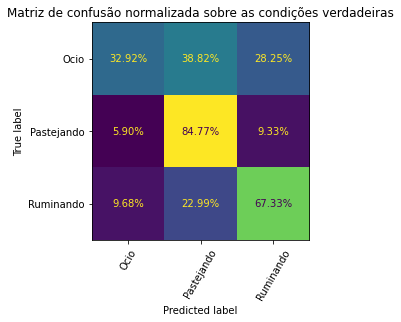

In [23]:
imprimeMatrizDeConfusão(y_test, rn_preds, rn_model)

#### RN: Busca de melhores hiper parâmetros 

In [61]:
rn_model = MLPClassifier(hidden_layer_sizes=(20,30,30,20), activation="tanh", verbose=0, learning_rate="adaptive", random_state=0)

In [62]:
%%time
rn_model.fit(X_train, y_train.values)

CPU times: user 24min 39s, sys: 17.8 s, total: 24min 56s
Wall time: 6min 15s


MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 30, 30, 20),
              learning_rate='adaptive', random_state=0, verbose=0)

In [63]:
rn_preds = rn_model.predict(X_test)

In [17]:
print("Acurácia:", accuracy_score(y_test, rn_preds)*100)

Acurácia: 71.52845260643993


In [64]:
classification_report_extendido(y_test, rn_preds)

{'Ocio': {'precision': 0.5880391890053068,
  'recall': 0.3506003569690086,
  'f1-score': 0.4392884371029225,
  'support': 24652,
  'specificity': 0.9374341275909814,
  'npv': 0.850007495409062},
 'Pastejando': {'precision': 0.7563004805234639,
  'recall': 0.8898830110372621,
  'f1-score': 0.8176718480138169,
  'support': 66502,
  'specificity': 0.6528364404311098,
  'npv': 0.8304154508823121},
 'Ruminando': {'precision': 0.668269905912091,
  'recall': 0.6287158145065398,
  'f1-score': 0.6478897208985704,
  'support': 30276,
  'specificity': 0.8963402593413344,
  'npv': 0.8790588083403267},
 'accuracy': 0.7152845260643993,
 'macro avg': {'precision': 0.6708698584802874,
  'recall': 0.6230663941709368,
  'f1-score': 0.6349500020051032,
  'support': 121430},
 'weighted avg': {'precision': 0.7001925085606908,
  'recall': 0.7152845260643993,
  'f1-score': 0.6985231077822714,
  'support': 121430}}

In [18]:
print(classification_report(y_test, rn_preds, digits=3))

              precision    recall  f1-score   support

        Ocio      0.588     0.351     0.439     24652
  Pastejando      0.756     0.890     0.818     66502
   Ruminando      0.668     0.629     0.648     30276

    accuracy                          0.715    121430
   macro avg      0.671     0.623     0.635    121430
weighted avg      0.700     0.715     0.699    121430



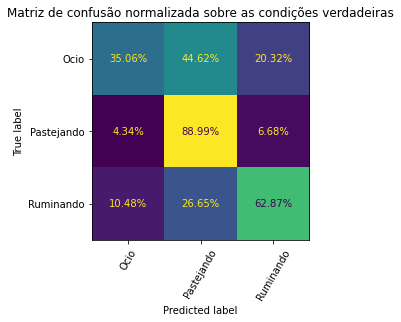

In [59]:
imprimeMatrizDeConfusão(y_test, rn_preds, rn_model)

### KNN

In [65]:
from sklearn.neighbors import KNeighborsClassifier

In [28]:
knn_model = KNeighborsClassifier(n_neighbors=10,  weights='distance', n_jobs=-1)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=10, weights='distance')

In [29]:
knn_preds = knn_model.predict(X_test)

print("Acurácia:", accuracy_score(y_test, knn_preds))

Acurácia: 0.7379230832578441


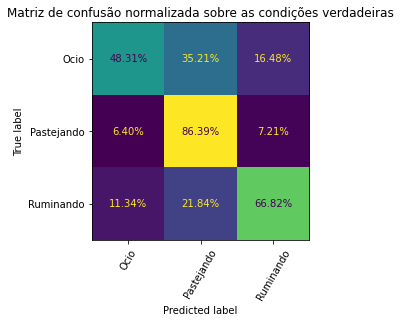

In [30]:
imprimeMatrizDeConfusão(y_test, knn_preds, knn_model)

#### KNN: Busca de melhores hiper parâmetros

In [56]:
def tune_knn(params):
    n_neighbors = params[0]
    weights = params[1]
    leaf_size = params[2]
    p = params[3]
    
    print(params, '\n')
    
    knn_Model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, leaf_size=leaf_size, p=p, n_jobs=-1)
    
    knn_Model.fit(X_train, y_train)
    
    preds = knn_Model.predict(X_test)
    
    return -accuracy_score(y_test, preds)

space = [(5, 50), #n_neighbors
         ['uniform', 'distance'], # weights
         [20,30,40,50,100], # leaf_size
         [1,2]] # p

In [ ]:
%%time
resultados_knn = gp_minimize(tune_knn, space, random_state=0, verbose=1, n_calls=30, n_random_starts=10, n_jobs=-1)

In [58]:
resultados_knn.x

[50, 'distance', 20, 2]

In [59]:
# Melhores hiper parâmetros para o conjunto PRO: n_neighbors=37, weights='distance', leaf_size=20, p=1, n_jobs=-1

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

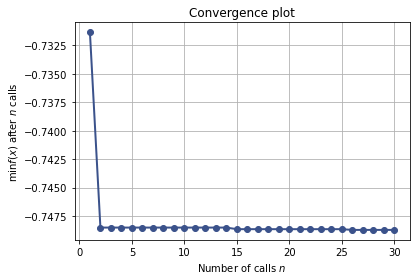

In [52]:
from skopt.plots import plot_convergence
plot_convergence(resultados_knn)

In [97]:
# Melhores hiper parâmetros para o conjunto PNP: n_neighbors=46, weights='distance', leaf_size=20, p=2, n_jobs=-1

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

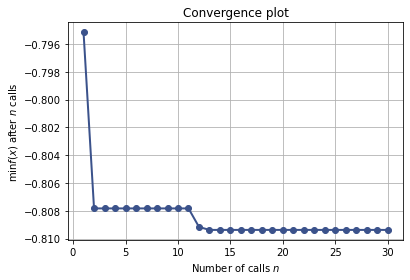

In [60]:
from skopt.plots import plot_convergence
plot_convergence(resultados_knn)

#### KNN: Treinamento com os melhores hiper parâmetros

In [129]:
%%time
knn_model = KNeighborsClassifier(n_neighbors=37, weights='distance', leaf_size=20, p=1, n_jobs=-1)

knn_model.fit(X_train, y_train)
preds = knn_model.predict(X_test)

CPU times: user 43.8 s, sys: 26.4 ms, total: 43.8 s
Wall time: 7.55 s


In [130]:
accuracy_score(y_test, preds)*100

74.64053364078069

In [131]:
classification_report_extendido(y_test, preds)

{'Ocio': {'precision': 0.6427971087577744,
  'recall': 0.4653577803018011,
  'f1-score': 0.5398715263888562,
  'support': 24652,
  'specificity': 0.9341275909814214,
  'npv': 0.8727590434723844},
 'Pastejando': {'precision': 0.789499973000702,
  'recall': 0.8794171603861538,
  'f1-score': 0.8320363072457995,
  'support': 66502,
  'specificity': 0.7161192834255753,
  'npv': 0.8306584449043375},
 'Ruminando': {'precision': 0.7008845358728437,
  'recall': 0.6830823094200026,
  'f1-score': 0.6918689259488482,
  'support': 30276,
  'specificity': 0.9031748469622836,
  'npv': 0.895619159513941},
 'accuracy': 0.7464053364078069,
 'macro avg': {'precision': 0.71106053921044,
  'recall': 0.6759524167026525,
  'f1-score': 0.6879255865278346,
  'support': 121430},
 'weighted avg': {'precision': 0.7376228422768307,
  'recall': 0.7464053364078069,
  'f1-score': 0.7377749730299396,
  'support': 121430}}

In [22]:
print(classification_report(y_test, preds, digits=3))

              precision    recall  f1-score   support

        Ocio      0.643     0.465     0.540     24652
  Pastejando      0.789     0.879     0.832     66502
   Ruminando      0.701     0.683     0.692     30276

    accuracy                          0.746    121430
   macro avg      0.711     0.676     0.688    121430
weighted avg      0.738     0.746     0.738    121430



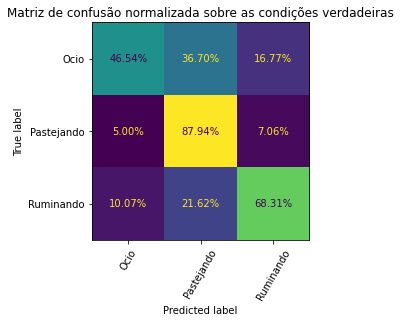

In [23]:
imprimeMatrizDeConfusão(y_test, preds, knn_model)

### Validação Exeterna com os dados do Leonardo

Leitura dos bancos de dados em DataFrame Pandas. 

In [143]:
caminho_dados_leo = 'Datasets/Leonardo/dados_pre_processados_leonardo.csv'

In [144]:
df_leo = pd.read_csv(caminho_dados_leo)

In [145]:
df_leo.head()

,SensorID,Date,Value,Voltage,X,Y,Z,Comportamento,Season_fall,Season_spring,Season_summer,magn,sma,ent,erg,pit,rol,icl
0,175810,2019-01-21 08:15:03,1.115,3.04,-0.171,1.115,0.242,Pastejando,0,0,1,1.153703,1.528,7.474426,1.771641,-12.108253,-8.719130,-81.476304
1,175810,2019-01-21 08:16:04,0.583,3.02,-0.702,0.071,0.583,Pastejando,0,0,1,0.915278,1.356,-0.089163,0.701798,-39.565868,-84.224766,-39.916535
2,175810,2019-01-21 08:16:05,0.683,3.01,-0.594,-0.026,0.683,Pastejando,0,0,1,0.905539,1.303,0.138071,0.672402,-48.959606,-92.506296,-49.007300
3,175810,2019-01-21 08:16:06,0.631,3.01,-0.706,0.059,0.631,Pastejando,0,0,1,0.948724,1.396,-0.031235,0.810140,-41.690272,-85.222926,-41.913249
4,175810,2019-01-21 08:16:07,0.604,3.01,-0.805,0.081,0.604,Pastejando,0,0,1,1.009654,1.490,-0.197988,1.039180,-36.742843,-84.254174,-37.126721


In [146]:
# Seleciona os abributos correspondentes da lista features_aplicaveis
df_leo = df_leo[features_aplicaveis]

In [147]:
df_leo = df_leo.rename({'X': 'a', 'Y': 'b', 'Z': 'c'}, axis=1)  

In [148]:
df_leo = df_leo.rename({'a': 'Y', 'b': 'Z', 'c': 'X'}, axis=1)  

In [149]:
df_leo = df_leo[features_aplicaveis]

#### Divisão entre variáveis preditoras(X) e variáveis de resposta(y)

In [150]:
# Conjunto de dados PRO: Pastejando x Ruminando x Ócio
y = df_leo.Comportamento
X = df_leo.drop('Comportamento', axis=1)

In [140]:
# Conjunto de dados PNP: Pastejando x Não Pastejando
y_pnp = y
y_pnp = y_pnp.replace(to_replace=['Ocio', 'Ruminando'], value='Não Pastejando')
y = y_pnp

In [151]:
# Para reescalar os dados
X_season = X[['Season_fall', 'Season_spring', 'Season_summer']]

X.drop(['Season_fall', 'Season_spring', 'Season_summer'], axis=1, inplace=True)

columns = X.columns
index = X.index

X = sc.transform(X)

X = pd.DataFrame(X, columns=columns, index=index)

X = pd.concat([X, X_season], axis=1)

#### Com LGBMClassifier

In [152]:
%%time
lgb_preds = lgb_model.predict(X)

accuracy_score(y, lgb_preds)*100

CPU times: user 5.62 s, sys: 7.7 ms, total: 5.63 s
Wall time: 765 ms


38.11610155468744

In [153]:
classification_report_extendido(y, lgb_preds)

{'Ocio': {'precision': 0.3759748875440924,
  'recall': 0.21311565624140144,
  'f1-score': 0.27203334269926005,
  'support': 54515,
  'specificity': 0.7717555986932437,
  'npv': 0.6031656459878999},
 'Pastejando': {'precision': 0.4439982948529311,
  'recall': 0.5661978746536668,
  'f1-score': 0.4977070760788304,
  'support': 57026,
  'specificity': 0.5067522232930355,
  'npv': 0.6267539756782039},
 'Ruminando': {'precision': 0.25652259942900757,
  'recall': 0.330504770922864,
  'f1-score': 0.2888517545953688,
  'support': 27458,
  'specificity': 0.7641943321289929,
  'npv': 0.8225955878095386},
 'accuracy': 0.3811610155468744,
 'macro avg': {'precision': 0.3588319272753437,
  'recall': 0.3699394339393107,
  'f1-score': 0.3528640577911531,
  'support': 138999},
 'weighted avg': {'precision': 0.38028557969389093,
  'recall': 0.3811610155468744,
  'f1-score': 0.3679410130677284,
  'support': 138999}}

In [154]:
print(classification_report(y, lgb_preds, digits=3))

              precision    recall  f1-score   support

        Ocio      0.376     0.213     0.272     54515
  Pastejando      0.444     0.566     0.498     57026
   Ruminando      0.257     0.331     0.289     27458

    accuracy                          0.381    138999
   macro avg      0.359     0.370     0.353    138999
weighted avg      0.380     0.381     0.368    138999



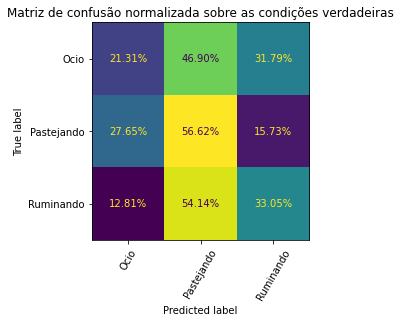

In [155]:
imprimeMatrizDeConfusão(y, lgb_preds, lgb_model)

#### Com RF

In [164]:
%%time
preds = rf_model.predict(X)

CPU times: user 4.64 s, sys: 44.6 ms, total: 4.68 s
Wall time: 672 ms


In [165]:
accuracy_score(y, preds)*100

39.92618651932748

In [166]:
classification_report_extendido(y, preds)

{'Ocio': {'precision': 0.37159845725305335,
  'recall': 0.12724938090433827,
  'f1-score': 0.18957954716259243,
  'support': 54515,
  'specificity': 0.861145305619999,
  'npv': 0.6046072915541298},
 'Pastejando': {'precision': 0.43601538724224864,
  'recall': 0.7612492547259145,
  'f1-score': 0.5544578482524315,
  'support': 57026,
  'specificity': 0.3149939614263233,
  'npv': 0.6547570747540319},
 'Ruminando': {'precision': 0.24792950693374421,
  'recall': 0.18752276203656493,
  'f1-score': 0.21353626674407994,
  'support': 27458,
  'specificity': 0.8599707730789575,
  'npv': 0.8113100625047577},
 'accuracy': 0.3992618651932748,
 'macro avg': {'precision': 0.35184778380968207,
  'recall': 0.35867379922227255,
  'f1-score': 0.31919122071970124,
  'support': 138999},
 'weighted avg': {'precision': 0.3735965853812863,
  'recall': 0.3992618651932748,
  'f1-score': 0.34400766250311754,
  'support': 138999}}

In [167]:
print(classification_report(y, preds, digits=3))

              precision    recall  f1-score   support

        Ocio      0.372     0.127     0.190     54515
  Pastejando      0.436     0.761     0.554     57026
   Ruminando      0.248     0.188     0.214     27458

    accuracy                          0.399    138999
   macro avg      0.352     0.359     0.319    138999
weighted avg      0.374     0.399     0.344    138999



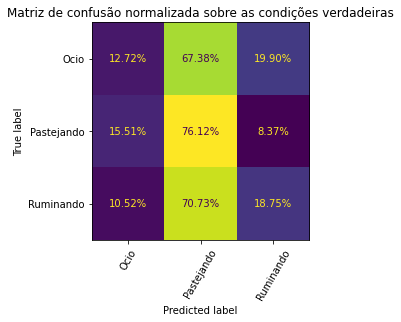

In [168]:
imprimeMatrizDeConfusão(y, preds, rf_model)

#### Com Gradient Boosting

In [180]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()

y_ordinal = ordinal_encoder.fit_transform(y.array.reshape(-1,1))

In [181]:
%%time
preds = gb_model.predict(X)

CPU times: user 7.31 s, sys: 20 ms, total: 7.33 s
Wall time: 973 ms


In [182]:
preds = ordinal_encoder.inverse_transform(preds.reshape(-1,1))
accuracy_score(y, preds)*100

41.52332031165692

In [183]:
classification_report_extendido(y, preds)

{'Ocio': {'precision': 0.43957823072771807,
  'recall': 0.19424011739888103,
  'f1-score': 0.26942649229046867,
  'support': 54515,
  'specificity': array([0.84020643]),
  'npv': array([0.61773562])},
 'Pastejando': {'precision': 0.44168199737187913,
  'recall': 0.7367691929996844,
  'f1-score': 0.5522803004909597,
  'support': 57026,
  'specificity': array([0.35210374]),
  'npv': array([0.65786115])},
 'Ruminando': {'precision': 0.25842810209754863,
  'recall': 0.18621166873042466,
  'f1-score': 0.21645534788222592,
  'support': 27458,
  'specificity': array([0.86846092]),
  'npv': array([0.81256396])},
 'accuracy': 0.4152332031165692,
 'macro avg': {'precision': 0.3798961100657152,
  'recall': 0.3724069930429967,
  'f1-score': 0.34605404688788477,
  'support': 138999},
 'weighted avg': {'precision': 0.40465675046327537,
  'recall': 0.4152332031165692,
  'f1-score': 0.37500667332256005,
  'support': 138999}}

In [184]:
print(classification_report(y, preds, digits=3))

              precision    recall  f1-score   support

        Ocio      0.440     0.194     0.269     54515
  Pastejando      0.442     0.737     0.552     57026
   Ruminando      0.258     0.186     0.216     27458

    accuracy                          0.415    138999
   macro avg      0.380     0.372     0.346    138999
weighted avg      0.405     0.415     0.375    138999



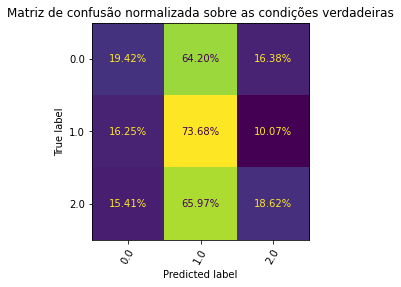

In [185]:
imprimeMatrizDeConfusão(y, preds, gb_model)

#### Com KNN

In [175]:
%%time

preds = knn_model.predict(X)

CPU times: user 2min 51s, sys: 291 ms, total: 2min 51s
Wall time: 24.2 s


In [176]:
accuracy_score(y, preds)*100

41.37511780660292

In [177]:
classification_report_extendido(y, preds)

{'Ocio': {'precision': 0.4270006760844038,
  'recall': 0.22012290195359074,
  'f1-score': 0.2904935970369653,
  'support': 54515,
  'specificity': 0.8093958619383552,
  'npv': 0.6166227817053817},
 'Pastejando': {'precision': 0.45496814391455076,
  'recall': 0.6812155858731105,
  'f1-score': 0.5455656203918264,
  'support': 57026,
  'specificity': 0.4322886804191624,
  'npv': 0.6609344399888091},
 'Ruminando': {'precision': 0.26121041078708057,
  'recall': 0.24269793866996867,
  'f1-score': 0.25161412120067966,
  'support': 27458,
  'specificity': 0.8310217767457706,
  'npv': 0.8167719650708892},
 'accuracy': 0.41375117806602923,
 'macro avg': {'precision': 0.38105974359534506,
  'recall': 0.3813454754988899,
  'f1-score': 0.36255777954315715,
  'support': 138999},
 'weighted avg': {'precision': 0.405724290757517,
  'recall': 0.41375117806602923,
  'f1-score': 0.38745965115477604,
  'support': 138999}}

In [178]:
print(classification_report(y, preds, digits=3))

              precision    recall  f1-score   support

        Ocio      0.427     0.220     0.290     54515
  Pastejando      0.455     0.681     0.546     57026
   Ruminando      0.261     0.243     0.252     27458

    accuracy                          0.414    138999
   macro avg      0.381     0.381     0.363    138999
weighted avg      0.406     0.414     0.387    138999



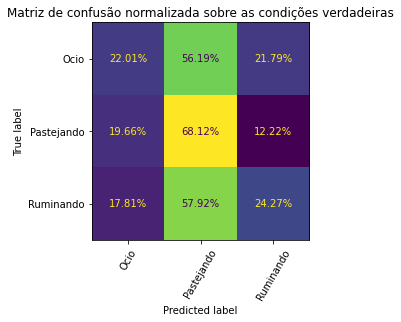

In [179]:
imprimeMatrizDeConfusão(y, preds, knn_model)

#### Com RN

In [186]:
%%time
preds = rn_model.predict(X)

CPU times: user 1.41 s, sys: 4.05 ms, total: 1.41 s
Wall time: 358 ms


In [187]:
accuracy_score(y, preds)*100

44.047798905028095

In [188]:
classification_report_extendido(y, preds)

{'Ocio': {'precision': 0.5280683461706637,
  'recall': 0.28799413005594793,
  'f1-score': 0.3727179925456402,
  'support': 54515,
  'specificity': 0.8339212158515222,
  'npv': 0.6447724859977304},
 'Pastejando': {'precision': 0.4313666183418684,
  'recall': 0.7252656682916564,
  'f1-score': 0.5409764232693502,
  'support': 57026,
  'specificity': 0.3349029558513169,
  'npv': 0.6366651205936921},
 'Ruminando': {'precision': 0.3112256329822989,
  'recall': 0.1517590501857382,
  'f1-score': 0.20402967170171615,
  'support': 27458,
  'specificity': 0.9173218816399351,
  'npv': 0.8145768648992915},
 'accuracy': 0.44047798905028096,
 'macro avg': {'precision': 0.42355353249827693,
  'recall': 0.38833961617778084,
  'f1-score': 0.37257469583890224,
  'support': 138999},
 'weighted avg': {'precision': 0.445559983161642,
  'recall': 0.44047798905028096,
  'f1-score': 0.40842516566715775,
  'support': 138999}}

In [189]:
print(classification_report(y, preds, digits=3))

              precision    recall  f1-score   support

        Ocio      0.528     0.288     0.373     54515
  Pastejando      0.431     0.725     0.541     57026
   Ruminando      0.311     0.152     0.204     27458

    accuracy                          0.440    138999
   macro avg      0.424     0.388     0.373    138999
weighted avg      0.446     0.440     0.408    138999



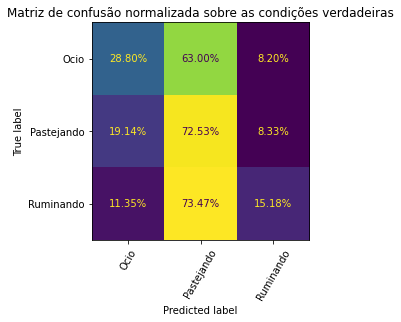

In [183]:
imprimeMatrizDeConfusão(y, preds, rn_model)

#### Com GLM

In [190]:
df = pd.concat([X, y], axis=1)

In [191]:
y, X = dmatrices( 'Comportamento ~ X + Y + Z + Season_fall + Season_spring + Season_summer + magn + sma + ent + pit + rol + icl', data=df, return_type='dataframe')

In [192]:
preds = glm_results.predict(X)

In [193]:
preds[3] = preds.median(axis=1)

In [194]:
preds = preds.reset_index(drop=True)

In [195]:
b = np.zeros((preds.shape[0], 3))

In [196]:
for i in range(preds.shape[0]):
    for j in range(3):
        if preds.loc[i,j] > preds.loc[i,3]:
            b[i,j] = 1
        else:
            b[i,j] = 0

In [197]:
preds = pd.DataFrame(b, columns=['Ocio', 'Pastejando', 'Ruminando'])

In [198]:
accuracy_score(y, preds)*100

32.113180670364535

In [201]:
print(classification_report(y, preds, digits=3, zero_division=True))

              precision    recall  f1-score   support

           0      1.000     0.000     0.000     54515
           1      0.366     0.773     0.497     57026
           2      0.029     0.019     0.023     27458

   micro avg      0.321     0.321     0.321    138999
   macro avg      0.465     0.264     0.173    138999
weighted avg      0.548     0.321     0.208    138999
 samples avg      0.321     0.321     0.321    138999



In [202]:
# Reverso de get_dummies
preds = preds.idxmax(axis=1)

In [203]:
y = y.rename(columns={"Comportamento[Ocio]" : "Ocio", "Comportamento[Pastejando]" : "Pastejando", "Comportamento[Ruminando]" : "Ruminando"})

In [204]:
y = y.idxmax(axis=1)

In [205]:
y = y.reset_index(drop=True)

In [206]:
classification_report_extendido(y, preds)

{'Ocio': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 54515,
  'specificity': 1.0,
  'npv': 0.6078029338340564},
 'Pastejando': {'precision': 0.36619952178533477,
  'recall': 0.7734717497281941,
  'f1-score': 0.4970643587229679,
  'support': 57026,
  'specificity': 0.068717748526954,
  'npv': 0.30364939895423426},
 'Ruminando': {'precision': 0.02851598296587785,
  'recall': 0.019265787748561438,
  'f1-score': 0.022995500880262556,
  'support': 27458,
  'specificity': 0.8384271254516277,
  'npv': 0.7764263416578109},
 'accuracy': 0.32113180670364533,
 'macro avg': {'precision': 0.1315718349170709,
  'recall': 0.2642458458255852,
  'f1-score': 0.17335328653441015,
  'support': 138999},
 'weighted avg': {'precision': 0.15587080331230854,
  'recall': 0.32113180670364533,
  'f1-score': 0.20846914426511137,
  'support': 138999}}

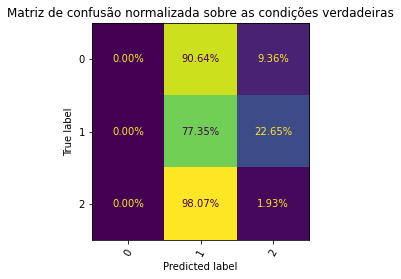

In [207]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y, preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format= '.2%', xticks_rotation=60, colorbar=False)
disp.ax_.set_title("Matriz de confusão normalizada sobre as condições verdadeiras")
plt.show()

### Teste de RF em CV

In [22]:
from sklearn.model_selection import cross_val_score

def get_score(n_estimators):
    clf = RandomForestClassifier(n_estimators, random_state=0, n_jobs=-1)
    scores = cross_val_score(clf, X_train, y_train, cv=3)
    return scores.mean()


In [14]:
results = {} 
n_estimators = 100
while n_estimators < 250:
    n_estimators += 50
    results[n_estimators] = get_score(n_estimators)

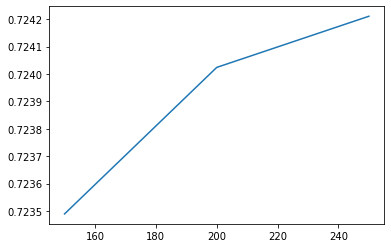

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()

### Lidando com dados desbalanceados

In [308]:
import seaborn as sns

In [309]:
df.Comportamento.value_counts()

Pastejando    332512
Ruminando     151381
Ocio          123257
Name: Comportamento, dtype: int64

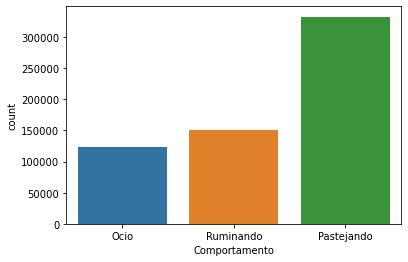

In [151]:
ax = sns.countplot(x="Comportamento", data=df)

In [152]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=150,
                              min_samples_split=30,
                              min_samples_leaf=1,
                              max_features='sqrt',
                              max_depth=100,
                              criterion='entropy',
                              bootstrap=False,
                              n_jobs=-1,
                              random_state=0)
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [153]:
accuracy_score(y_test, preds)*100

74.16462434448046

In [156]:
print (classification_report(y_test, preds))

              precision    recall  f1-score   support

        Ocio       0.65      0.43      0.52     30838
  Pastejando       0.78      0.89      0.83     83380
   Ruminando       0.70      0.67      0.68     37570

    accuracy                           0.74    151788
   macro avg       0.71      0.66      0.68    151788
weighted avg       0.73      0.74      0.73    151788



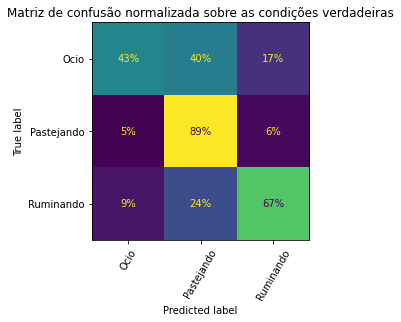

In [157]:
imprimeMatrizDeConfusão(y_test, preds, model)

#### Aplicando NearMiss

In [18]:
from imblearn.under_sampling import NearMiss
nr = NearMiss()

In [165]:
X, y = nr.fit_resample(X, y)

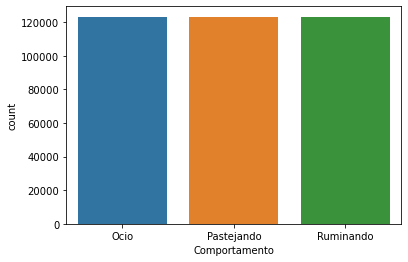

In [166]:
ax = sns.countplot(x=y)

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [168]:
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [169]:
accuracy_score(y_test, preds)*100

68.94086085479701

In [170]:
print (classification_report(y_test, preds))

              precision    recall  f1-score   support

        Ocio       0.66      0.61      0.64     30976
  Pastejando       0.70      0.73      0.72     30906
   Ruminando       0.70      0.73      0.72     30561

    accuracy                           0.69     92443
   macro avg       0.69      0.69      0.69     92443
weighted avg       0.69      0.69      0.69     92443



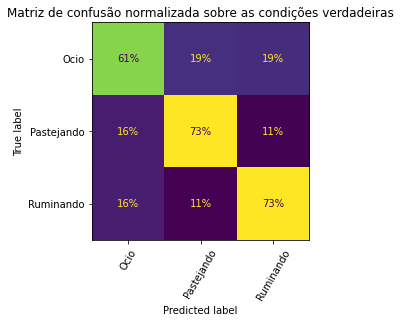

In [171]:
imprimeMatrizDeConfusão(y_test, preds, model)

#### Aplicando o SMOTE

In [302]:
from imblearn.over_sampling import SMOTE
smt = SMOTE()

In [303]:
X = df.drop("Comportamento", axis = 1)
y = df.Comportamento

In [304]:
# Visualizando a quantidade de dados por classe
y.value_counts()

Pastejando    332512
Ruminando     151381
Ocio          123257
Name: Comportamento, dtype: int64

In [305]:
X, y = smt.fit_resample(X, y)

In [306]:
# Visualizando a quantidade de dados por classe
y.value_counts()

Ocio          332512
Ruminando     332512
Pastejando    332512
Name: Comportamento, dtype: int64

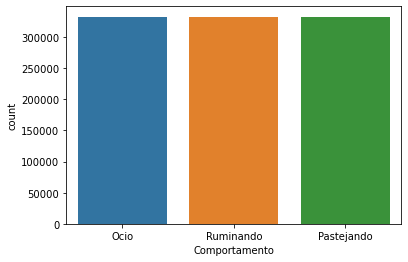

In [310]:
ax = sns.countplot(x=y)

In [311]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [312]:
# Para reescalar os dados
from sklearn.preprocessing import StandardScaler

X_train_season = X_train[['Season_fall', 'Season_spring', 'Season_summer']]
X_test_season =  X_test[['Season_fall', 'Season_spring', 'Season_summer']]

X_train.drop(['Season_fall', 'Season_spring', 'Season_summer'], axis=1, inplace=True)
X_test.drop(['Season_fall', 'Season_spring', 'Season_summer'], axis=1, inplace=True)

columns = X_train.columns
index_train = X_train.index
index_test = X_test.index


sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

X_train = pd.DataFrame(X_train, columns=columns, index=index_train)
X_test = pd.DataFrame(X_test, columns=columns, index=index_test)

X_train = pd.concat([X_train, X_train_season], axis=1)
X_test = pd.concat([X_test, X_test_season], axis=1)

In [65]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=150,
                              min_samples_split=30,
                              min_samples_leaf=1,
                              max_features='sqrt',
                              max_depth=100,
                              criterion='entropy',
                              bootstrap=False,
                              n_jobs=-1,
                              random_state=0)
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [66]:
accuracy_score(y_test, preds)*100

76.60595707824078

In [67]:
print (classification_report(y_test, preds))

              precision    recall  f1-score   support

        Ocio       0.76      0.72      0.74     83256
  Pastejando       0.75      0.80      0.77     83127
   Ruminando       0.79      0.78      0.78     83001

    accuracy                           0.77    249384
   macro avg       0.77      0.77      0.77    249384
weighted avg       0.77      0.77      0.77    249384



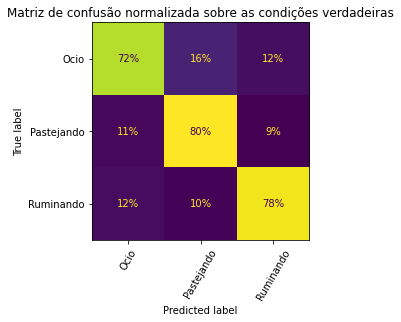

In [69]:
imprimeMatrizDeConfusão(y_test, preds, model)

### Treinamento e validação variando o tamanho do conjunto de dados

In [36]:
fracoes = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] # Frações testadas

df_amostras = {}
for fracao in fracoes:
    df_amostras[fracao] = df.sample(frac=fracao, random_state=0)

In [37]:
def amostrarEvalidar(df_amostras, model):
    print("Nome do modelo: ", type(model).__name__)
    for fracao in df_amostras:
        y = df_amostras[fracao].Comportamento
        X = df_amostras[fracao].drop('Comportamento', axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 0)
        
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        print("Parcela usada:", fracao*100,"%", " Acurácia:",accuracy_score(y_test, preds)*100)

#### Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=0, n_jobs=-1)
amostrarEvalidar(df_amostras, rf_model)

Nome do modelo:  RandomForestClassifier
Parcela usada: 0.1 %  Acurácia: 62.295081967213115
Parcela usada: 0.5 %  Acurácia: 63.48684210526315
Parcela usada: 1.0 %  Acurácia: 67.9835390946502
Parcela usada: 5.0 %  Acurácia: 69.94400527009222
Parcela usada: 10.0 %  Acurácia: 70.25446759449889
Parcela usada: 20.0 %  Acurácia: 71.96327102034094
Parcela usada: 30.0 %  Acurácia: 72.23915012764556
Parcela usada: 40.0 %  Acurácia: 72.32561969859178
Parcela usada: 50.0 %  Acurácia: 72.68549781767273
Parcela usada: 60.0 %  Acurácia: 72.90757363638859
Parcela usada: 70.0 %  Acurácia: 73.10502229385537
Parcela usada: 80.0 %  Acurácia: 73.36840154821708
Parcela usada: 90.0 %  Acurácia: 73.66841435852388
Parcela usada: 100 %  Acurácia: 73.59136951329984


#### LGBMClassifier

In [41]:
from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier(n_jobs=-1, random_state=0)
amostrarEvalidar(df_amostras, lgb_model)

Nome do modelo:  LGBMClassifier
Parcela usada: 0.1 %  Acurácia: 54.09836065573771
Parcela usada: 0.5 %  Acurácia: 62.82894736842105
Parcela usada: 1.0 %  Acurácia: 67.4074074074074
Parcela usada: 5.0 %  Acurácia: 69.25230566534914
Parcela usada: 10.0 %  Acurácia: 69.19212715144528
Parcela usada: 20.0 %  Acurácia: 70.69916824507946
Parcela usada: 30.0 %  Acurácia: 70.5454445633973
Parcela usada: 40.0 %  Acurácia: 70.49328831425512
Parcela usada: 50.0 %  Acurácia: 70.55093469488595
Parcela usada: 60.0 %  Acurácia: 70.54818962914162
Parcela usada: 70.0 %  Acurácia: 70.48975894401242
Parcela usada: 80.0 %  Acurácia: 70.76504982294325
Parcela usada: 90.0 %  Acurácia: 70.67171758763622
Parcela usada: 100 %  Acurácia: 70.71728567899201


#### KNN

In [39]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_jobs=-1)
amostrarEvalidar(df_amostras, knn_model)

Nome do modelo:  KNeighborsClassifier
Parcela usada: 0.1 %  Acurácia: 54.09836065573771
Parcela usada: 0.5 %  Acurácia: 55.5921052631579
Parcela usada: 1.0 %  Acurácia: 56.21399176954732
Parcela usada: 5.0 %  Acurácia: 59.255599472990774
Parcela usada: 10.0 %  Acurácia: 60.7839907765791
Parcela usada: 20.0 %  Acurácia: 63.246314749238245
Parcela usada: 30.0 %  Acurácia: 63.61689862472206
Parcela usada: 40.0 %  Acurácia: 64.59482829613769
Parcela usada: 50.0 %  Acurácia: 64.81100222350325
Parcela usada: 60.0 %  Acurácia: 65.20080155919734
Parcela usada: 70.0 %  Acurácia: 65.46864154539358
Parcela usada: 80.0 %  Acurácia: 65.68805072881496
Parcela usada: 90.0 %  Acurácia: 66.09569299184716
Parcela usada: 100 %  Acurácia: 66.33863131021988


#### Redes Neurais

In [43]:
%%capture --no-stdout

from sklearn.neural_network import MLPClassifier

rn_model = MLPClassifier(random_state=0)
amostrarEvalidar(df_amostras, rn_model)

Nome do modelo:  MLPClassifier
Parcela usada: 0.1 %  Acurácia: 53.278688524590166
Parcela usada: 0.5 %  Acurácia: 58.55263157894737
Parcela usada: 1.0 %  Acurácia: 58.93004115226338
Parcela usada: 5.0 %  Acurácia: 60.918972332015805
Parcela usada: 10.0 %  Acurácia: 61.269867413324555
Parcela usada: 20.0 %  Acurácia: 63.14749238244256
Parcela usada: 30.0 %  Acurácia: 65.12668478410058
Parcela usada: 40.0 %  Acurácia: 66.47657086387218
Parcela usada: 50.0 %  Acurácia: 66.19122127974964
Parcela usada: 60.0 %  Acurácia: 66.21373081885311
Parcela usada: 70.0 %  Acurácia: 64.60394583593134
Parcela usada: 80.0 %  Acurácia: 67.02627027917319
Parcela usada: 90.0 %  Acurácia: 67.03816556406525
Parcela usada: 100 %  Acurácia: 66.4876883801367


#### Gradient Boosting

In [44]:
from xgboost import XGBClassifier

from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()

df_oe = df
df_oe['Comportamento'] = ordinal_encoder.fit_transform(df_oe['Comportamento'].array.reshape(-1,1))

df_amostras_oe = {}
for fracao in fracoes:
    df_amostras_oe[fracao] = df_oe.sample(frac=fracao, random_state=0)

xgb_model = XGBClassifier(use_label_encoder=False, random_state=0, n_jobs=-1, verbosity = 0)
amostrarEvalidar(df_amostras_oe,  xgb_model)

Nome do modelo:  XGBClassifier
Parcela usada: 0.1 %  Acurácia: 54.91803278688525
Parcela usada: 0.5 %  Acurácia: 62.00657894736842
Parcela usada: 1.0 %  Acurácia: 66.66666666666666
Parcela usada: 5.0 %  Acurácia: 68.19828722002636
Parcela usada: 10.0 %  Acurácia: 68.89566005105823
Parcela usada: 20.0 %  Acurácia: 70.91328337313678
Parcela usada: 30.0 %  Acurácia: 70.93249883334705
Parcela usada: 40.0 %  Acurácia: 70.94210656345219
Parcela usada: 50.0 %  Acurácia: 71.1586922506794
Parcela usada: 60.0 %  Acurácia: 71.18367234895275
Parcela usada: 70.0 %  Acurácia: 71.16739803061141
Parcela usada: 80.0 %  Acurácia: 71.48665898048259
Parcela usada: 90.0 %  Acurácia: 71.36438917712078
Parcela usada: 100 %  Acurácia: 71.3810425759697
